In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from pyfrac.visualisation.plotting_support import explode_volume

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load velocity model
dimlims = 0.41  # 40cm cubed
dx = dy = dz = 0.01  # 1cm
nx = ny = nz = int(dimlims/dx)
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

# Subsurface properties
vp = 5260  # m/s
vs = 3260  # m/s
rho = 2590;  # kg/m3

print(x)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 ]


In [3]:
# Get source locations
sx,sy,sz = np.meshgrid(x,y,z)
src_locs = np.array([sx.ravel(), sy.ravel(), sz.ravel()]).T

In [4]:
# Get receiver locations
face_locs = dx + np.arange(nx-2)*dx
fx,fy = np.meshgrid(face_locs,face_locs)
fx = fx.ravel()
fy = fy.ravel()
f0,f1 = np.zeros_like(fx),np.array([np.ones_like(fx)*0.4])

rx = np.vstack([f0, f1, fx, fx, fx, fx])
ry = np.vstack([fx, fx, f0, f1, fy, fy])
rz = np.vstack([fy, fy, fy, fy, f0, f1])
               
rec_locs = np.array([rx.ravel(), ry.ravel(), rz.ravel()]).T

In [5]:
tt_table = np.zeros([len(src_locs),len(rec_locs)])
print(tt_table.shape)

for i,src in enumerate(src_locs):
    dists = np.sqrt((rec_locs[:,0]-src[0])**2 + (rec_locs[:,1]-src[1])**2 + (rec_locs[:,2]-src[2])**2)
    tt_table[i] = dists/vp

(68921, 9126)


In [6]:
tt_table.max()

0.00012952894370262983

In [7]:
tt_table_3D = tt_table.T.reshape(len(rec_locs),nx,ny,nz)
tt_table_3D.shape

(9126, 41, 41, 41)

In [8]:
np.argwhere(src_locs==[0.2,0.2,0.2])

array([[   20,     2],
       [   61,     2],
       [  102,     2],
       ...,
       [68818,     2],
       [68859,     2],
       [68900,     2]])

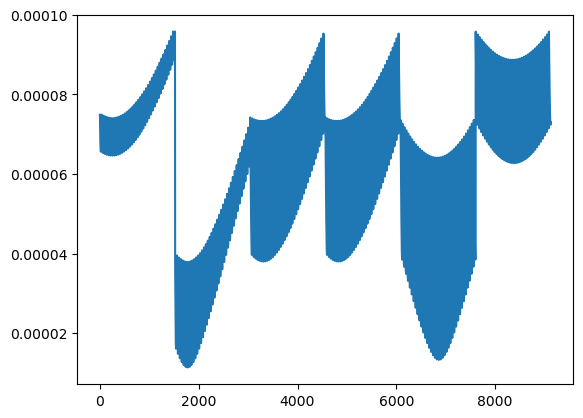

In [9]:
plt.plot(tt_table[35021])

In [19]:
def poi_index(poi_xyz, src_locs):
    return np.where((src_locs == (poi_xyz[0], poi_xyz[1], poi_xyz[2])).all(axis=1))[0][0]


In [20]:
middle_poi_id = poi_index([0.2, 0.2, 0.2], src_locs)

px, py, pz = 0.2, 0.2, 0.2
poi_id = np.where((src_locs == (px, py, pz)).all(axis=1))[0][0]


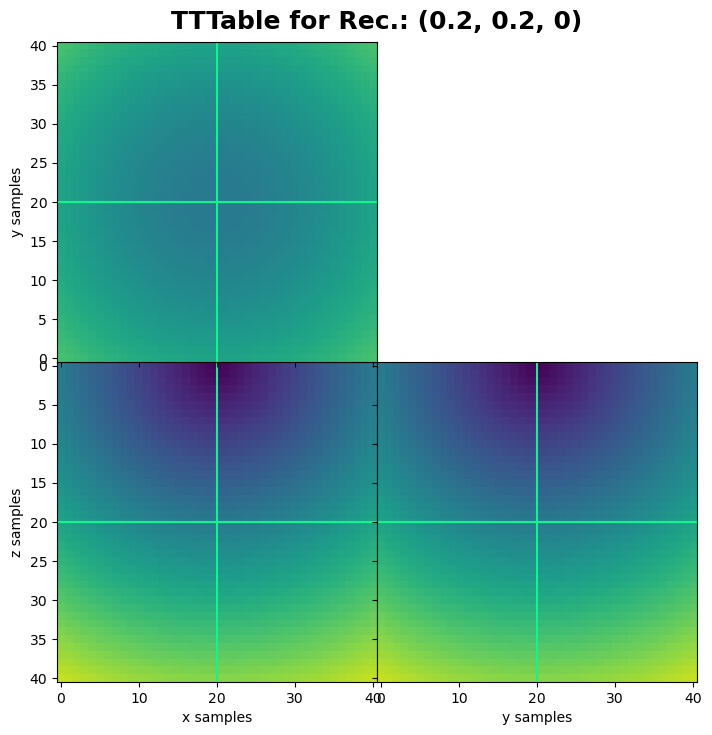

In [73]:
rx, ry, rz = 0.2, 0.2,0
rec_id = np.where((rec_locs == (rx, ry, rz)).all(axis=1))[0][0]
fig,axs = explode_volume(tt_table_3D[rec_id].transpose([2,1,0]), 
               t=20, 
               x=20, 
               y=20,
               cmap='viridis',               
               clipval=[0,np.max(tt_table_3D[rec_id])],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='TTTable for Rec.: '+str((rx, ry, rz)),
               )
fig.savefig('./Figures/BoE_TTcalcs_R3D.eps', format='eps')

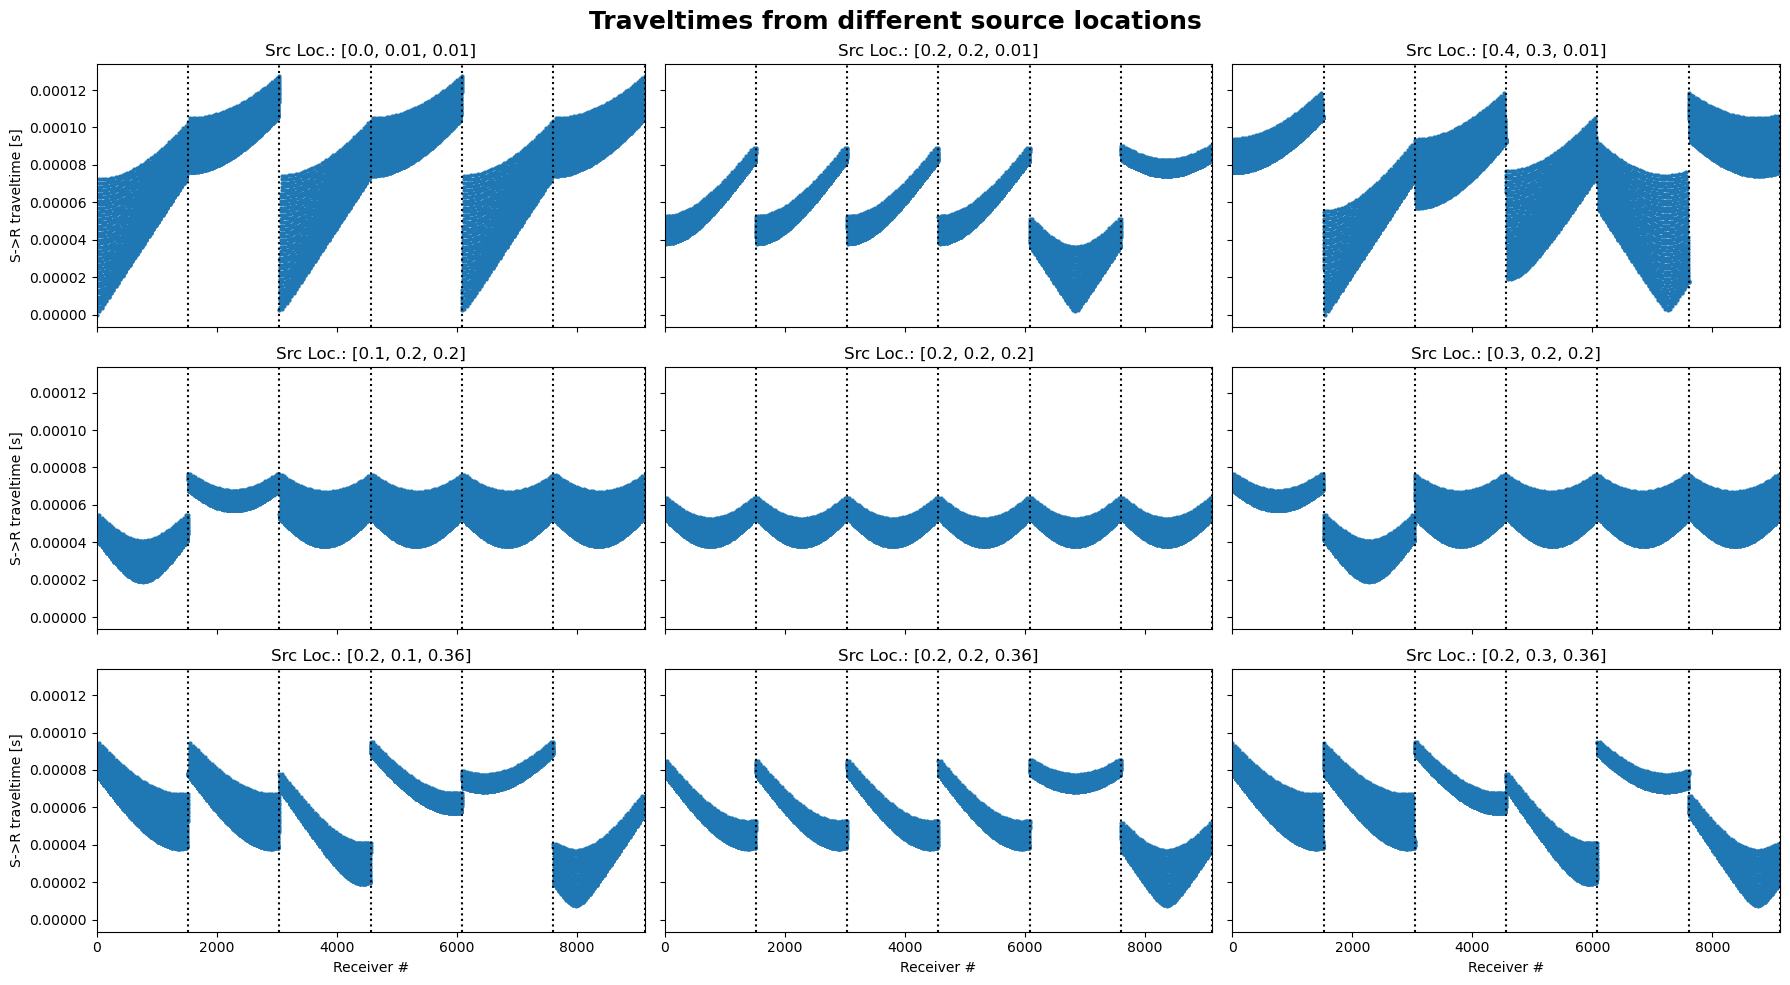

In [56]:
poi_list = [[0.0, 0.01, 0.01],
            [0.2, 0.2, 0.01],
            [0.4, 0.3, 0.01],
            [0.1, 0.2, 0.2],
            [0.2, 0.2, 0.2],            
            [0.3, 0.2, 0.2],
            [0.2, 0.1, 0.36],
            [0.2, 0.2, 0.36],
            [0.2, 0.3, 0.36],
           ]

fig,axs = plt.subplots(3,3,figsize=[18,10], sharex=True, sharey=True)
for i,poi in enumerate(poi_list):
    poi_id = poi_index(poi, src_locs)
    axs.ravel()[i].scatter(np.arange(len(rec_locs)), tt_table[poi_id], s=4)
    axs.ravel()[i].set_title('Src Loc.: '+str(poi))

for ax in axs.ravel(): 
    for i in range(1,7):
        ax.axvline(i*39**2,c='k',ls=':')
    ax.set_xlim(0,9126)
fig.suptitle('Traveltimes from different source locations', fontsize=18, fontweight='bold')
for ax in axs[:,0]:ax.set_ylabel('S->R traveltime [s]')
for ax in axs[-1]:ax.set_xlabel('Receiver #')
fig.tight_layout()
fig.savefig('./Figures/BoE_TTcalcs.eps', format='eps')



In [10]:
Fs = 125000
dt = 1/Fs
print(dt)

ttdiff_table = np.zeros_like(tt_table)
for i,tts in enumerate(tt_table):
    ttdiff_table[i] = tts - np.min(tts)

8e-06


In [53]:
ttt_to_timesteps = np.round(tt_table/dt)
ttt_to_timesteps[:10]

array([[ 0.,  1.,  1., ..., 16., 16., 16.],
       [ 0.,  0.,  1., ..., 16., 16., 16.],
       [ 0.,  1.,  1., ..., 16., 16., 16.],
       ...,
       [ 1.,  2.,  2., ..., 15., 15., 15.],
       [ 2.,  2.,  2., ..., 15., 15., 15.],
       [ 2.,  2.,  2., ..., 15., 15., 15.]])

In [76]:
np.max(ttt_to_timesteps.T.reshape(len(rec_locs),nx,ny,nz)[rec_id])

12.0

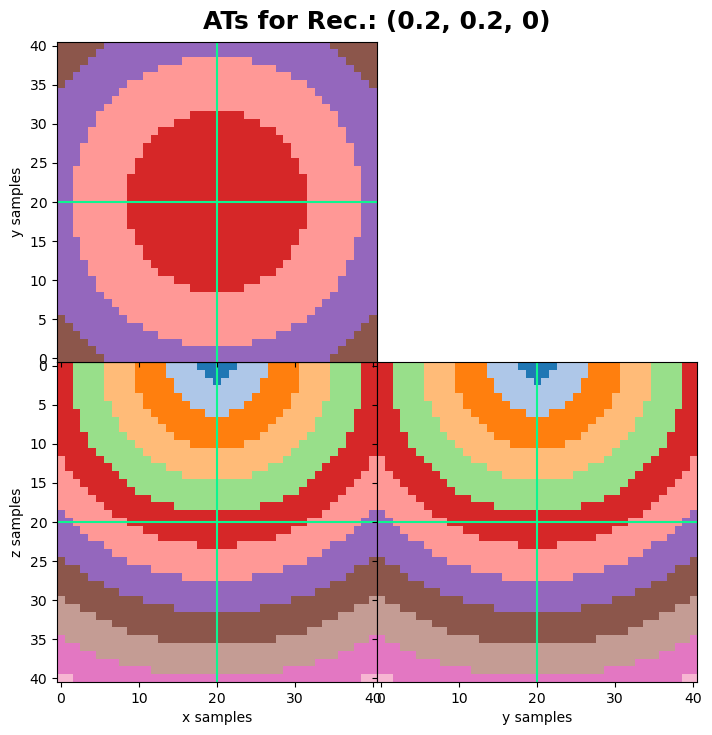

In [75]:
rx, ry, rz = 0.2, 0.2,0
rec_id = np.where((rec_locs == (rx, ry, rz)).all(axis=1))[0][0]
fig,axs = explode_volume(ttt_to_timesteps.T.reshape(len(rec_locs),nx,ny,nz)[rec_id].transpose([2,1,0]), 
               t=20, 
               x=20, 
               y=20,
               cmap='tab20',               
               clipval=[0,16],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='ATs for Rec.: '+str((rx, ry, rz)),
               )
fig.savefig('./Figures/BoE_ATindices_R3D.eps', format='eps')

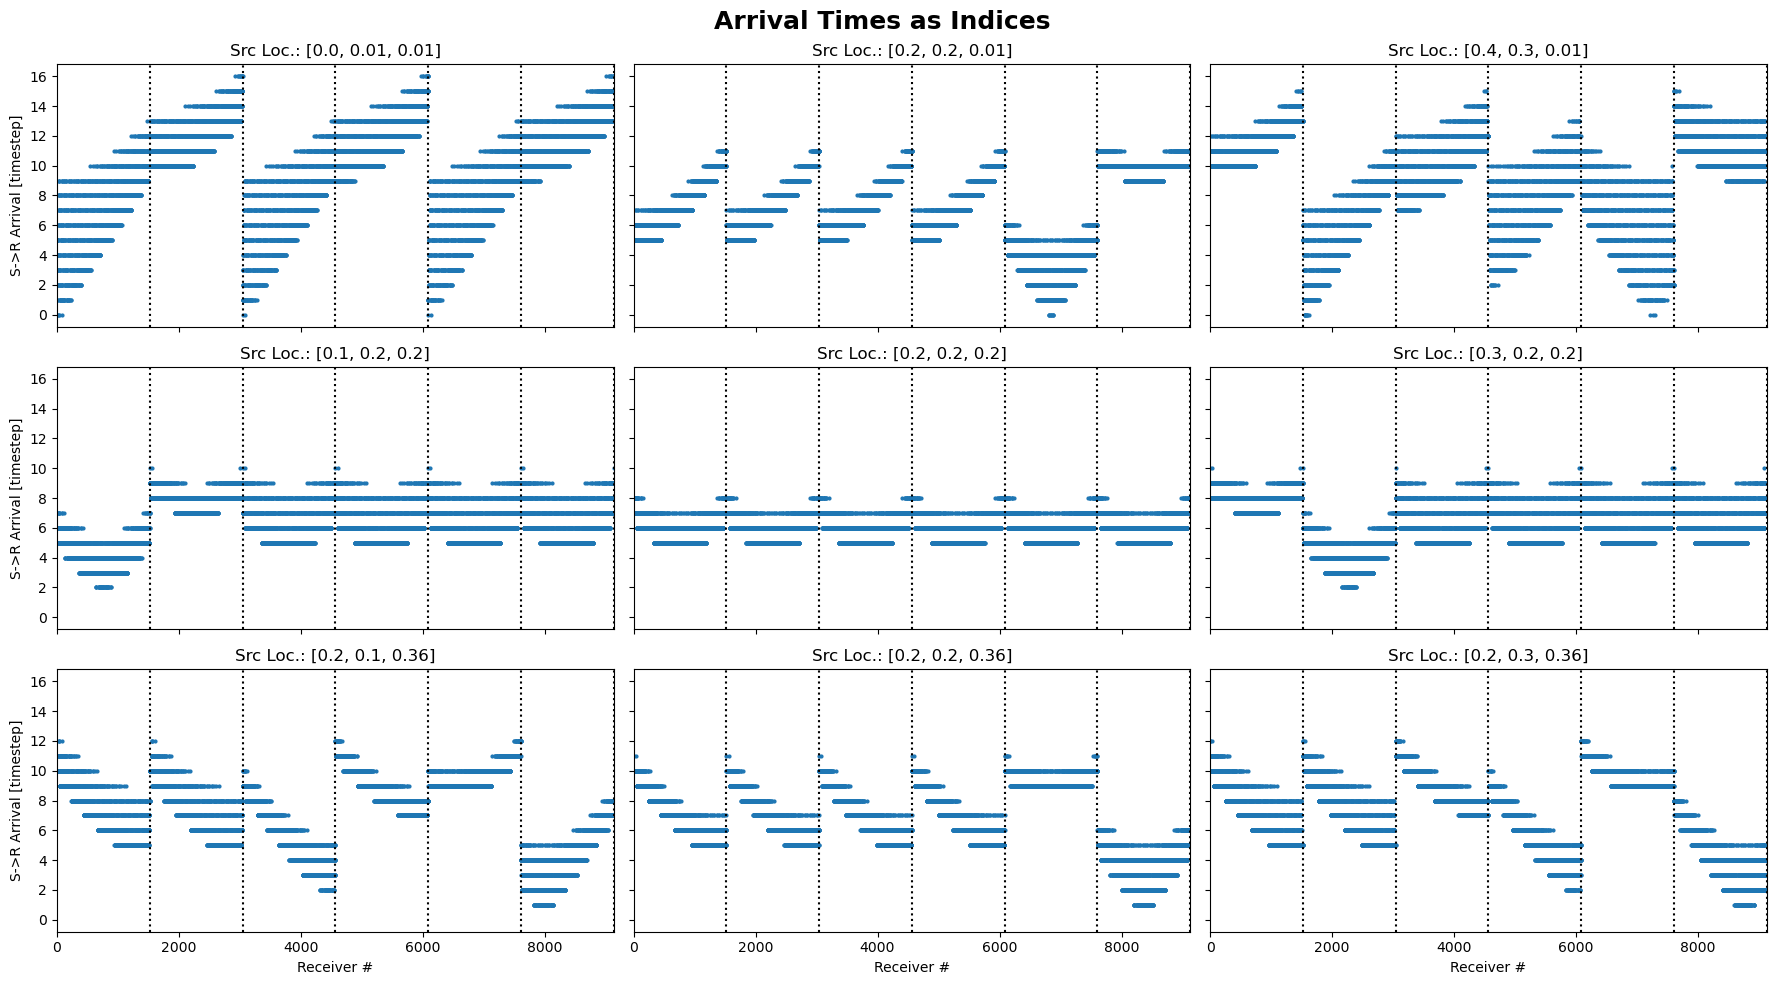

In [57]:
fig,axs = plt.subplots(3,3,figsize=[18,10], sharex=True, sharey=True)
for i,poi in enumerate(poi_list):
    poi_id = poi_index(poi, src_locs)
    axs.ravel()[i].scatter(np.arange(len(rec_locs)), ttt_to_timesteps[poi_id], s=4)
    axs.ravel()[i].set_title('Src Loc.: '+str(poi))

for ax in axs.ravel(): 
    for i in range(1,7):
        ax.axvline(i*39**2,c='k',ls=':')
    ax.set_xlim(0,9126)
fig.suptitle('Arrival Times as Indices', fontsize=18, fontweight='bold')
for ax in axs[:,0]:ax.set_ylabel('S->R Arrival [timestep]')
for ax in axs[-1]:ax.set_xlabel('Receiver #')
fig.tight_layout()
fig.savefig('./Figures/BoE_ATs_indices.eps', format='eps')


In [78]:
len(np.unique(ttt_to_timesteps[poi_id]))

12

In [79]:
ttt_to_timesteps.shape

(68921, 9126)

In [80]:
atindex_range = np.zeros([ttt_to_timesteps.shape[0]])
for i,tt in enumerate(ttt_to_timesteps):
    atindex_range[i] = len(np.unique(tt))

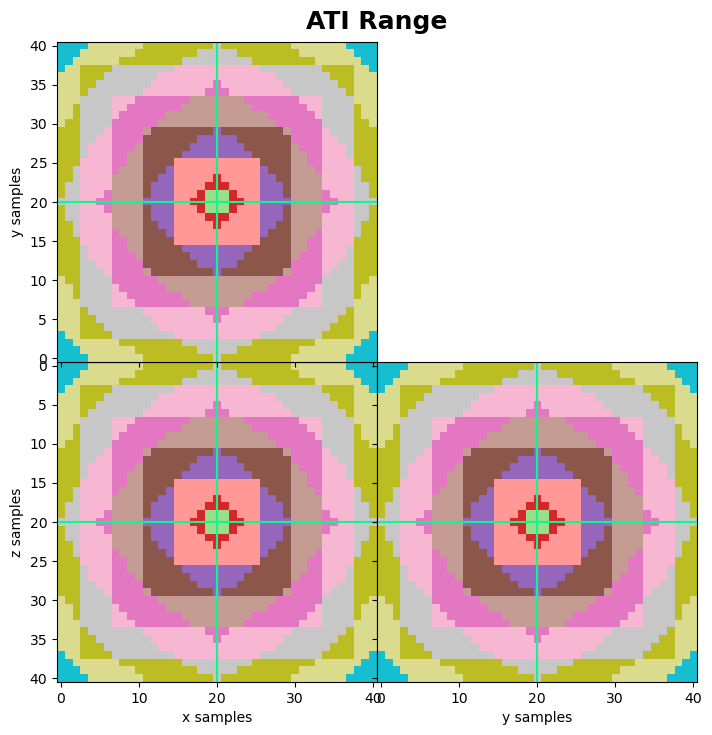

In [92]:
fig,axs = explode_volume(atindex_range.reshape(nx,ny,nz).transpose([2,1,0]), 
               t=20, 
               x=20, 
               y=20,
               cmap='tab20',               
               clipval=[0,16],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='x', ylabel='y',
               title='ATI Range',
               )
fig.savefig('./Figures/BoE_ATI_range.eps', format='eps')

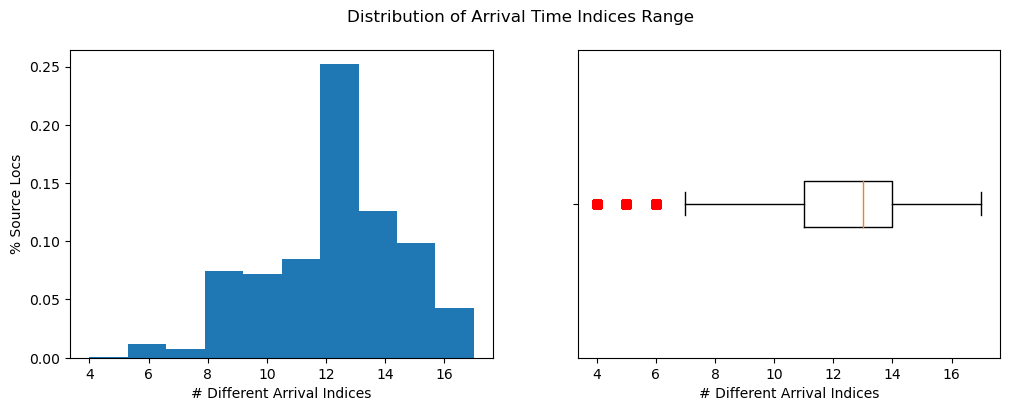

In [91]:
fig,axs = plt.subplots(1,2, figsize=[12,4])
axs[0].hist(atindex_range, density=True)
axs[1].boxplot(atindex_range, 0, 'rs', 0)
axs[1].set_yticklabels([])
fig.suptitle('Distribution of Arrival Time Indices Range')
axs[0].set_ylabel('% Source Locs')
for ax in axs: ax.set_xlabel('# Different Arrival Indices')
fig.savefig('./Figures/BoE_ATIrange_distribution.eps', format='eps')

# TRANSDUCERS

In [ ]:
wide_loc = [